# Test notebook

## Graphe par genre

J'essaie de créer un graph par genre. Pour le moment j'ai une fonction qui prends le tableau `movies` et qui crée une adjacency matrix avec.
Ce graphe pourrait être utile pour étudier une distribution des genres ou pour mapper les nodes selon les genres.
Pour obtenir l'adjacency : `adjacency = genre_graph.make_genre_adjacency(movies)`

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx
import logging
import json
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

import src.load_data as ldata
import src.genre_graph as genre_graph
import src.test_success as tsuccess

In [2]:
(movies,people) = ldata.load_dataframes();

2019-01-17 23:29:02,965 | INFO : Data loaded !


In [3]:
list_genres=movies[['genres_names','genres']].copy()
list_genres=list_genres.drop_duplicates()
list_genres=list_genres.set_index('genres') 
list_genres

,genres_names
genres,
0,Action
1,Adventure
2,Fantasy
3,Animation
4,Science Fiction
5,Drama
6,Thriller
7,Family
8,Comedy


In [4]:
moviesFiltered = ldata.filter_movies_by_years(movies, pd.to_datetime(f'1960-01-01').date(), pd.to_datetime(f'2020-01-01').date())



In [5]:
adjacency = genre_graph.make_genre_adjacency(moviesFiltered)

Text(0.5,1.05,'adjacency matrix')

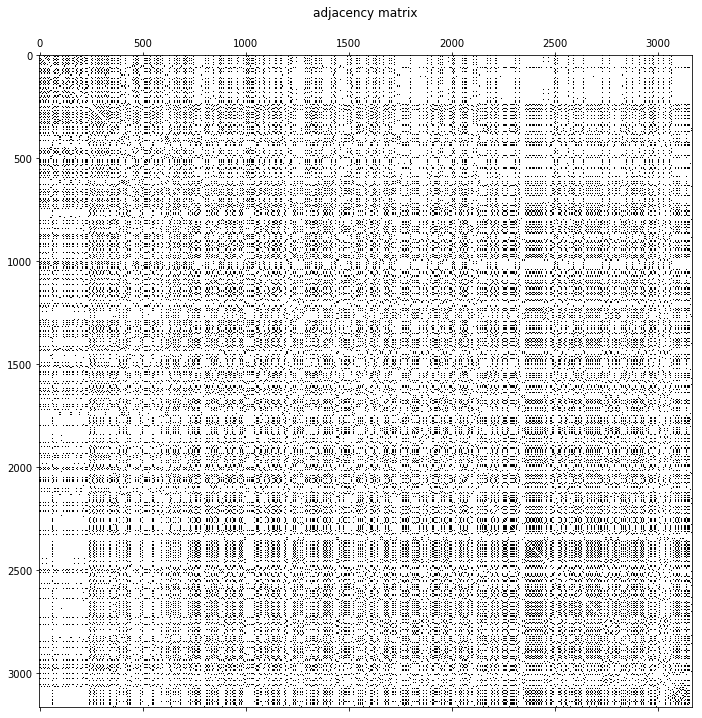

In [6]:
plt.figure(figsize=(12, 12))
plt.spy(adjacency)
plt.title('adjacency matrix')

In [7]:
#G_test = nx.from_numpy_matrix(adjacency)
#nx.number_connected_components(G_test)
#Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
#coords_test = nx.spring_layout(G_test,k=0.03)

In [8]:
#labels = moviesFiltered['genres'].iloc[np.sort(nx.nodes(G_test))]

#plt.figure(figsize=(15, 15))

#im=nx.draw_networkx_nodes(G_test, coords_test, node_size=50,node_color=labels, cmap='tab20')

#labels2 = moviesFiltered['budget'].iloc[np.sort(nx.nodes(G_test))]
#im=nx.draw_networkx_nodes(G_test, coords_test,node_size=50, node_color=labels2)

#nx.draw_networkx_edges(G_test, coords_test, alpha=0.5, width=1)
#plt.title('Graph of genres')
#plt.colorbar(im);

## Étude du ROI

Ici j'ai fait un petit histogramme du ROI moyen par genre. C'est intéressant et surprenant de voir que les genre qui rapportent le plus sont l'*horreur* et les *documentaires*.

In [9]:
perGenreROI = genre_graph.compute_ROI_genre(moviesFiltered)

           genres_names  ROI_fraction  number_films
genres                                             
0                Action             0             0
1             Adventure             0             0
2               Fantasy             0             0
3             Animation             0             0
4       Science Fiction             0             0
5                 Drama             0             0
6              Thriller             0             0
7                Family             0             0
8                Comedy             0             0
9               History             0             0
10                  War             0             0
11              Western             0             0
12              Romance             0             0
13                Crime             0             0
14              Mystery             0             0
15               Horror             0             0
17                Music             0             0
16          

## Visualisation du ROI par genre par décade

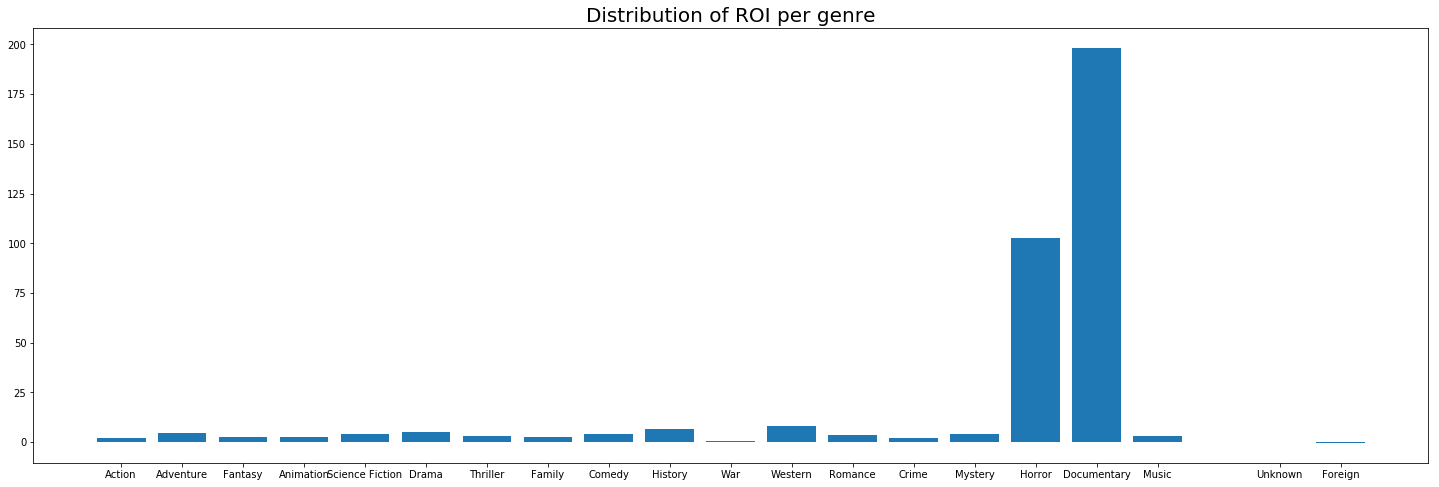

In [10]:
plt.figure(figsize = (25,8))
plt.bar(x=perGenreROI.index,height=perGenreROI.loc[:,'ROI_fraction'],tick_label=perGenreROI.loc[:,'genres_names'])
plt.title('Distribution of ROI per genre',fontsize=20)
plt.savefig('distribution_roi_per_genre.eps', format='eps', dpi=1000)
plt.show()

In [11]:
#for startYear in range(1960, 2010):
#    endYear = startYear + 10
#    moviesFiltered = ldata.filter_movies_window_years(movies, startYear, endYear)
#    adjacency = genre_graph.make_genre_adjacency(moviesFiltered)
#    perGenreROI = genre_graph.compute_ROI_genre(moviesFiltered)
#    plt.figure(figsize = (25,8))
#    plt.bar(x=perGenreROI.index,height=perGenreROI.loc[:,'ROI_fraction'],tick_label=perGenreROI.loc[:,'genres_names'])
#    axes = plt.gca()
#    axes.set_ylim([0,300])
#    plt.title(f'Distribution of ROI per genre between {startYear} and {endYear}',fontsize=20)
#    plt.savefig(f'./roi_per_genre/roi_per_genre_{startYear}_{endYear}.png', format='png', dpi=200)

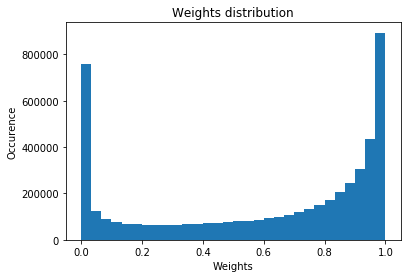

In [12]:
(adjacencyBudget,movies_filtered_by_budget) = ldata.make_budget_based_adjacency(moviesFiltered)

movies2 = movies_filtered_by_budget.copy()
movies2['original_language'] = pd.factorize(movies2['original_language'])[0]
data_kmeans = movies2.loc[:,('original_language','vote_average','vote_count')]
#data_kmeans = movies2.loc[:,('genres','ROI')]
predictedLabels = tsuccess.compute_kmeans(data_kmeans.values, 2)

Text(0.5,1.05,'Reordered with Kmeans adjacency matrix of the movies connected by their budgets. The genre and the ROI where used to perform the clustering')

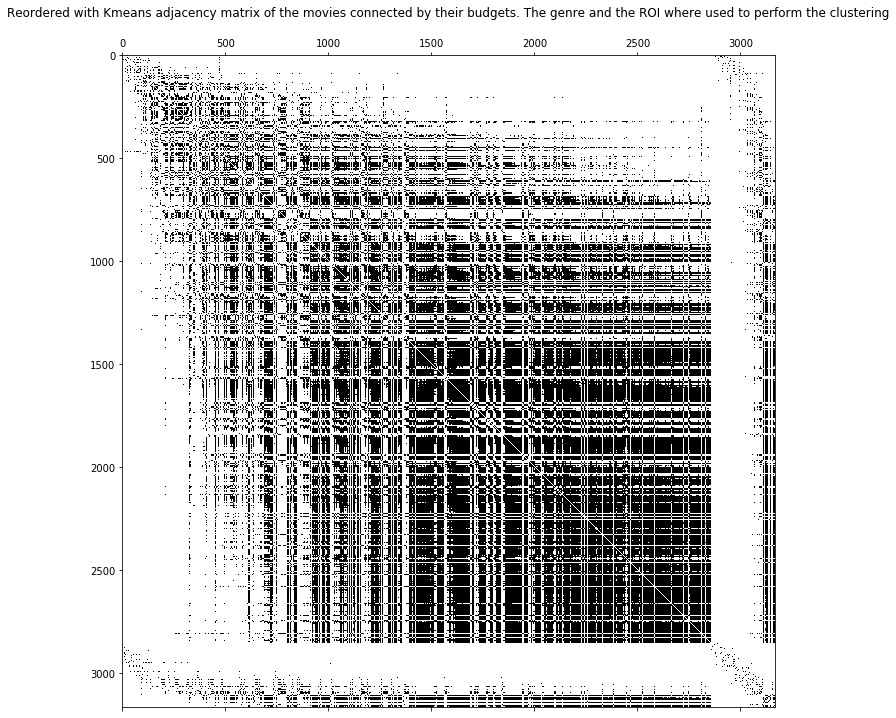

In [13]:
newAdjacency = tsuccess.reorder_adjacency(adjacencyBudget, predictedLabels)
#newAdjacency = adjacencyBudget
plt.figure(figsize=(12, 12))
plt.spy(newAdjacency)
plt.title('Reordered with Kmeans adjacency matrix of the movies connected by their budgets. The genre and the ROI where used to perform the clustering', fontsize=12)

## Test d'embedding du actor graph sur les coordonnées du budget.

1. Make actor graph
1. Make budget graph
1. Compute coordinates for budget graph
1. Plot graph

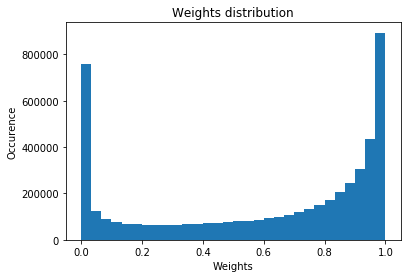

In [14]:
(adjacencyBudget,movies_filtered_by_budget) = ldata.make_budget_based_adjacency(moviesFiltered)

In [15]:
features_actors=ldata.create_features(movies_filtered_by_budget,people);

In [16]:
features_movies=ldata.load_features();
adjacencyActorsCrew=ldata.make_adjacency_from_feature_matrix(features_movies)

In [17]:
#adjacencyActorsCrew = np.load('./data/adjacency_actors_crew.npy');

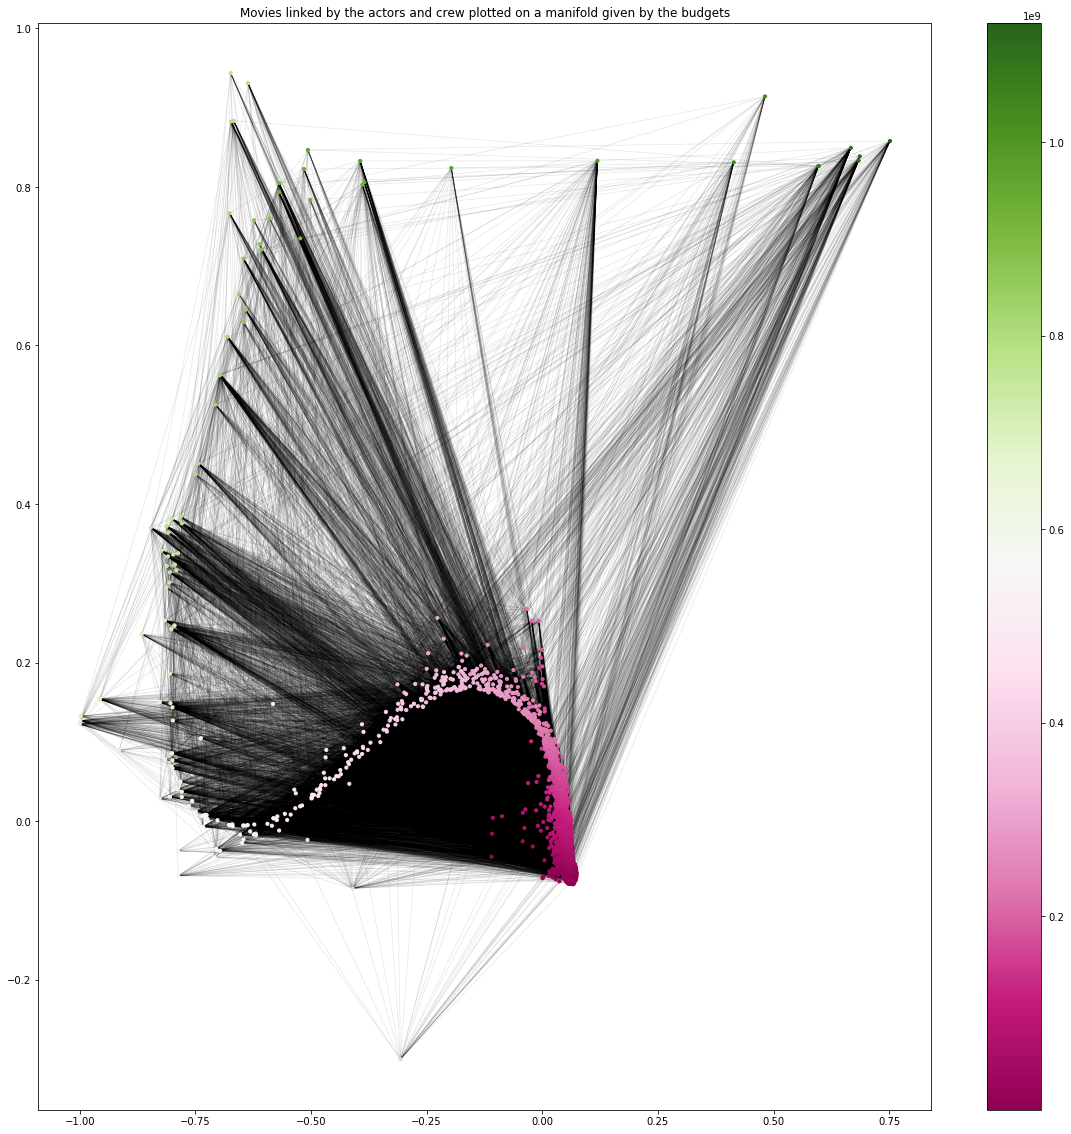

In [18]:
graphActorsCrew = nx.from_numpy_matrix(adjacencyActorsCrew)
graphBudget = nx.from_numpy_matrix(adjacencyBudget)

nodesGc = max(nx.connected_components(graphBudget), key=len)

graphBudget = nx.subgraph(graphBudget, nodesGc)
graphActorsCrew = nx.subgraph(graphActorsCrew, nodesGc)

coordsBudget = nx.spring_layout(graphBudget,k=0.03)

plt.figure(figsize=(20, 20))
labels = movies_filtered_by_budget['revenue'].iloc[np.sort(nx.nodes(graphActorsCrew))]
im=nx.draw_networkx_nodes(graphActorsCrew, coordsBudget, node_size=10, node_color=labels, cmap='PiYG')
nx.draw_networkx_edges(graphActorsCrew, coordsBudget, alpha=0.1, width=0.7)
plt.title('Movies linked by the actors and crew plotted on a manifold given by the budgets')
plt.colorbar(im);
plt.savefig('./pictures/graph_movies_plot_on_budget.png', dpi=300)

(3145, 2)
3145


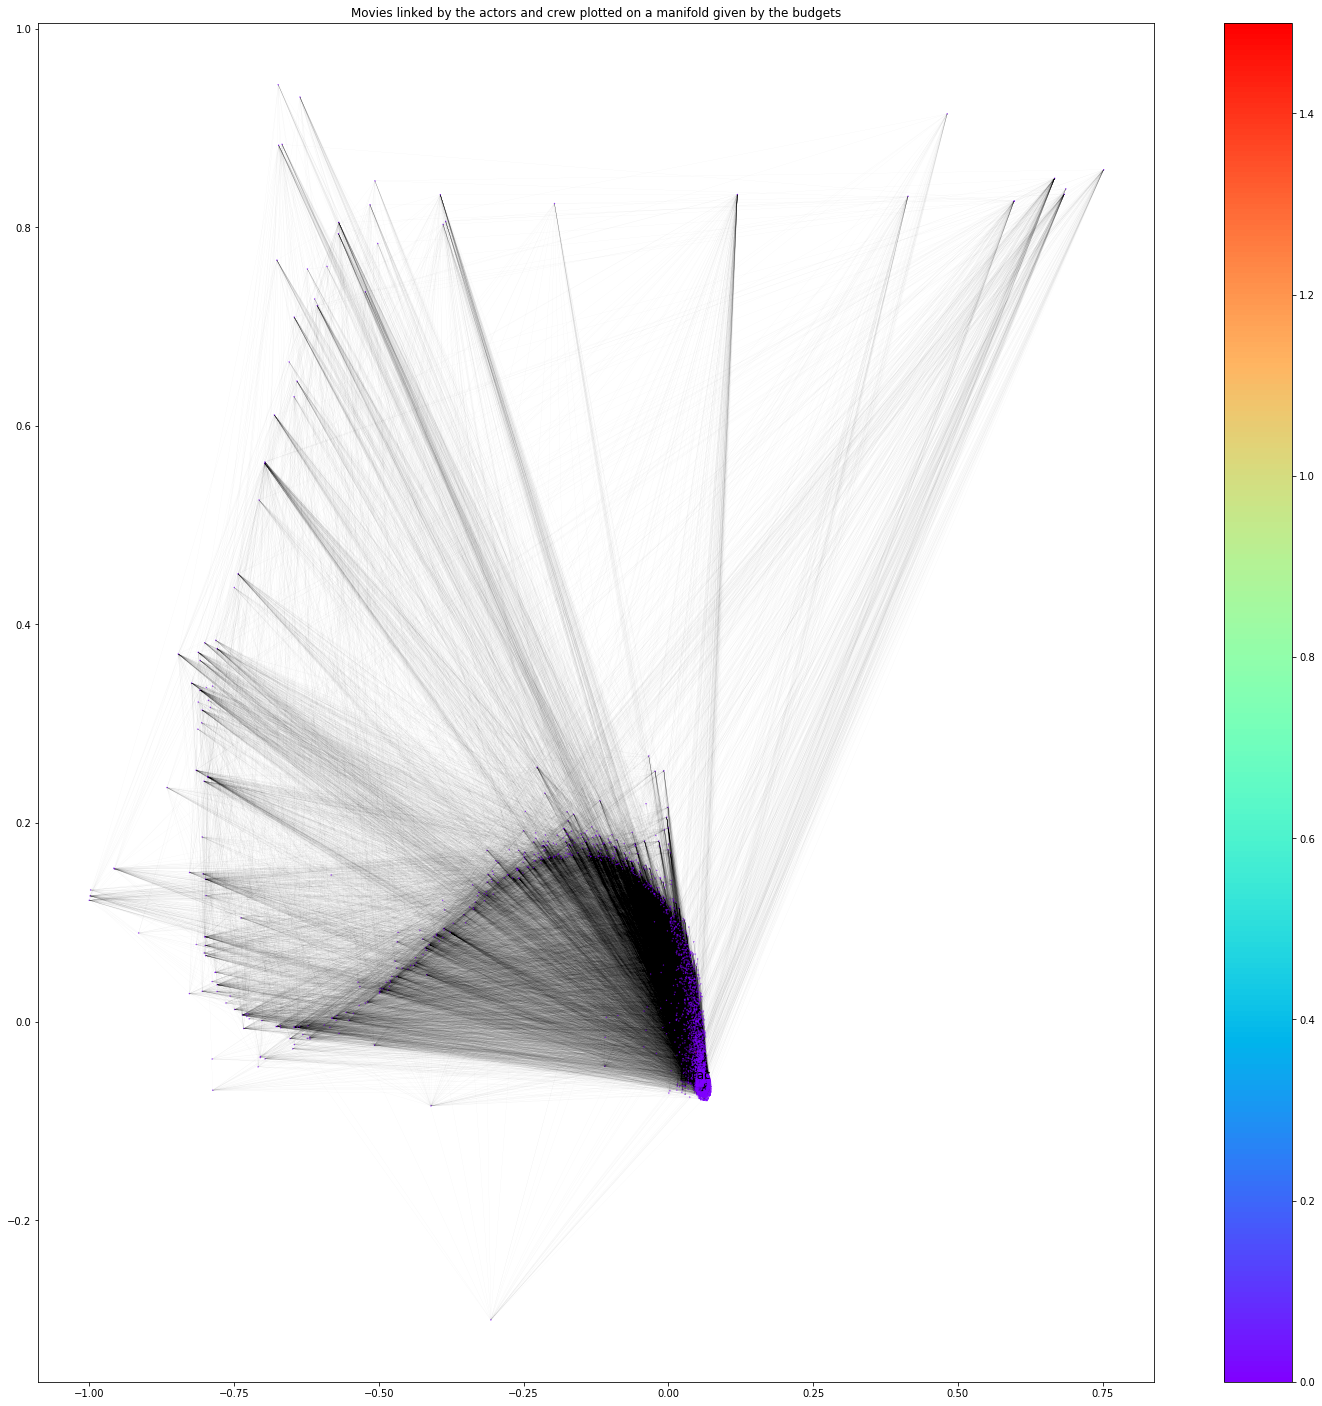

In [42]:
coordsBudgetGSP = np.zeros((len(coordsBudget),2))
print(coordsBudgetGSP.shape)
print(len(coordsBudget))
j = 0
for i in coordsBudget:
    coordsBudgetGSP[j] = coordsBudget[i]
    j = j+1

graphActorsCrewGSP = pg.graphs.Graph(nx.adjacency_matrix(graphActorsCrew), coords=coordsBudgetGSP)

signal = np.zeros(len(coordsBudget))

signal[920] = 1.5
label= {920:"Dirac"}

#plt.figure(figsize=(20, 20))
#axes = plt.gca()
#pg.plotting.plot_signal(graphActorsCrewGSP, signal, vertex_size=1, ax=axes)

sizes = 2*(signal+1)

plt.figure(figsize=(25, 25))
im=nx.draw_networkx_nodes(graphActorsCrew, coordsBudget, node_size=0.1, node_color=signal, cmap='rainbow', alpha=1)
nx.draw_networkx_edges(graphActorsCrew, coordsBudget, alpha=0.1, width=0.1)
nx.draw_networkx_labels(graphActorsCrew, coordsBudget, labels=label)
plt.title('Movies linked by the actors and crew plotted on a manifold given by the budgets')
plt.colorbar(im);
plt.savefig('./pictures/graph_movies_plot_on_budget_dirac.png', dpi=300)

2019-01-18 00:56:58,602:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (3145 x 3145) may take some time.


2019-01-18 00:56:58,602 | WARNING : Computing the full eigendecomposition of a large matrix (3145 x 3145) may take some time.


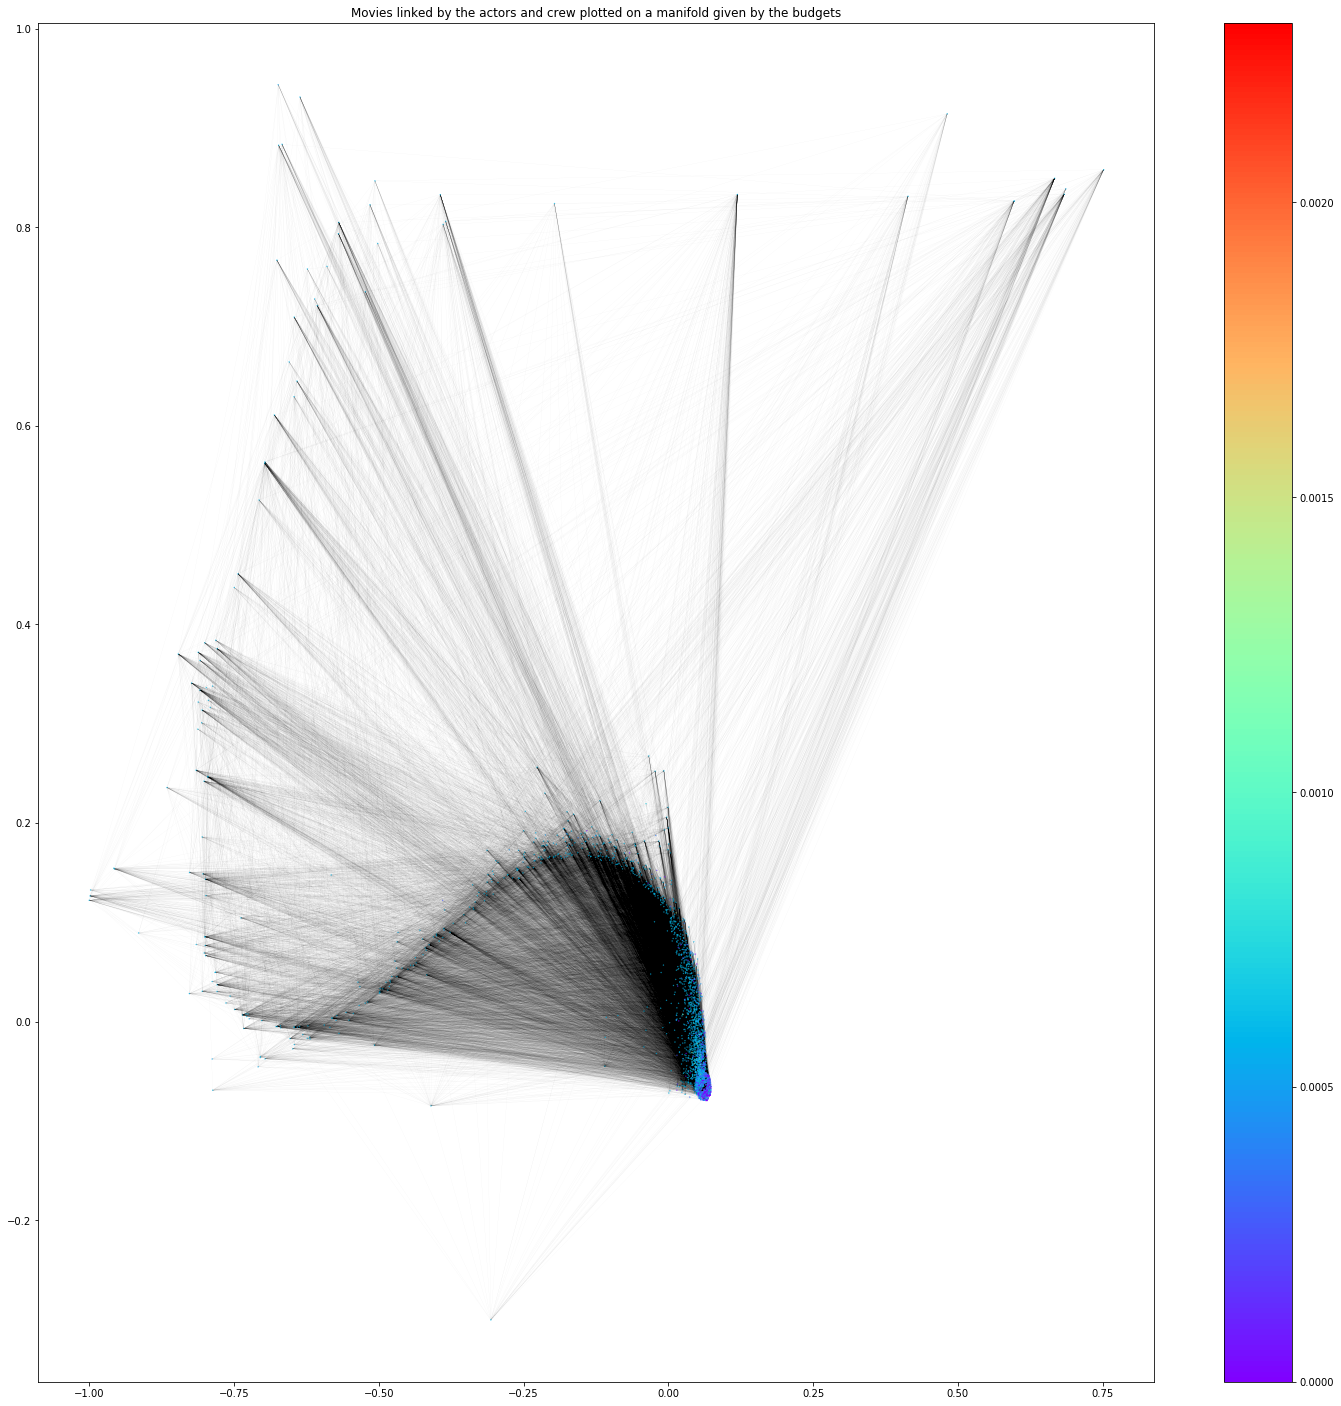

In [43]:
graphActorsCrewGSP.compute_fourier_basis()
heat_kernel = pg.filters.Heat(graphActorsCrewGSP, tau=100)
filtered_signal = heat_kernel.filter(signal)

#plt.figure(figsize=(30, 30))
#axes = plt.gca()
#pg.plotting.plot_signal(graphActorsCrewGSP, filtered_signal, save_as='./pictures/movies_dirac_on_actor.png', vertex_size=1, ax=axes)

plt.figure(figsize=(25, 25))
im=nx.draw_networkx_nodes(graphActorsCrew, coordsBudget, node_size=0.1, node_color=filtered_signal, cmap='rainbow', alpha=1)
nx.draw_networkx_edges(graphActorsCrew, coordsBudget, alpha=0.1, width=0.1)
plt.title('Movies linked by the actors and crew plotted on a manifold given by the budgets')
plt.colorbar(im);
plt.savefig('./pictures/graph_movies_plot_on_budget_heat_diffused_dirac.png', dpi=300)


array([8., 8., 8., ..., 8., 8., 8.])